# Figure 3: Fine-mapping and LDSC analysis of HQ versus LQ samples

In [1]:
# Import basic stuffs

import os, sys, re, glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load Basic analytic data for gkmQC paper
# exec(open("../scripts/__scratch__basic_import.py").read())

import pickle

### ENCODE & roadmap info
## All ENCODE metadata
print("Load ENCODE metadata table")
encode_df = pd.read_table("../data/encode_metadata_info_latest.txt", index_col="acc_peak")

# Load sample id sample types dictionary
f = open("../data/sid_stype_dic.pkl", "rb")
sid_stype_dic = pickle.load(f)
f.close()
encode_df.loc[:, "sample_abbr"] = encode_df["acc_sample"].map(sid_stype_dic)
#for param, analysis_dict in zip(param_list, analysis_dict_list):
#    encode_df.loc[:,param] = encode_df.index.map(analysis_dict)

## ENTEx tissue info data
print("Load ENTEx tissue-quality mapping")
entex_df = pd.read_table("../data/entx_tissue_info.txt", index_col="fid")

Load ENCODE metadata table
Load ENTEx tissue-quality mapping


## Basic parameters
(1) dAUC, SPOT2, peak/read counts, m-value

In [3]:
import pickle, requests, json
headers = {'accept': 'application/json'}

## SPOT2 scores
spot2_dic_pkl_file = "../data/prefix_spot2_dic.pkl"
f = open(spot2_dic_pkl_file, "rb")
prefix_spot2_dic = pickle.load(f)
f.close()

# Read counts
readc_dic_pkl_file = "../data/prefix_readc_dic.pkl"
f = open(readc_dic_pkl_file, "rb")
prefix_readc_dic = pickle.load(f)
f.close()

# peak count dic
prefix_pcount_dic_pkl = "../data/prefix_pcount_dic.pkl"
f = open(prefix_pcount_dic_pkl, "rb")
prefix_pcount_dic = pickle.load(f)
f.close()
    
# peak specificity
f = open("../data/prefix_ps_dic.pkl", "rb")
prefix_ps_dic = pickle.load(f)
f.close()
    
# dAUC
prefix_dauc_dic_pkl = "../data/prefix_dauc_dic.pkl"
f = open(prefix_dauc_dic_pkl, "rb")
prefix_dauc_dic = pickle.load(f)
f.close()
    
# new gkmQC
# score1 = (1 - auc_min/auc_max) / n
# score2 = (auc_max ** 2 - auc_min ** 2) / n
# score3 = (auc_max - auc_min) / ((auc_max + auc_min) * n)
# score4 = ((auc_max + auc_min) / 2 * n) / (auc_max - auc_min)
# score5 = sum(auc_scores) / (auc_max - auc_min)

prefix_gkmqc_dic_pkl = "../data/prefix_gkmqc_dic.pkl"
f = open(prefix_gkmqc_dic_pkl, "rb")
prefix_gkmqc_dic = pickle.load(f)
f.close()

In [8]:
import subprocess
lo_file = "/reference_databases/ReferenceGenome/liftover_chain/hg38/hg38ToHg19.over.chain.gz"

def hist_norm_weight(inputs):
    weights = list(map(lambda x: np.ones_like(x) / float(len(x)), inputs))
    return weights

chr_list = list(map(lambda x: "chr" + str(x), range(1, 23)))
def calc_peak_specificity_list(r):
    peak_shortest_dist_dic = {}
    r_lines = r.split('\n')
    for line in r_lines:
        line_tab = line.split('\t')
        if line_tab[3] == '.':    
            continue
        query_peak_acc = (line_tab[0], int(line_tab[1]), int(line_tab[2]))  
        targt_peak_acc = (line_tab[3], int(line_tab[4]), int(line_tab[5]))
        if line_tab[0] != line_tab[3]:
            continue    
        shortest_dist = np.inf
        if query_peak_acc in peak_shortest_dist_dic:
            shortest_dist = peak_shortest_dist_dic[query_peak_acc]
        query_summit = int((query_peak_acc[1] + query_peak_acc[2])/2)
        targt_summit = int((targt_peak_acc[1] + targt_peak_acc[2])/2)
        curr_dist = abs(query_summit - targt_summit)
        if curr_dist < shortest_dist:
            peak_shortest_dist_dic[query_peak_acc] = curr_dist
    return peak_shortest_dist_dic

## Fine-mapping variants
egfr_fmapping = "../data/egfr_fine_mapping_e300.bed"
#egfr_fmapping = "../data/egfr_fm_pstr50_e300.bed"
#egfr_fmapping = "../data/egfr_eqtl_coloc_mapping_e300.bed"
prefix_fmapping_dist_dic = {}
prefix_fmapping_cnt_dic = {}
prefix_fmapping_dic_dic = {}
for test_acc in sample_dic['embryos_kidney']:
    print(test_acc)
    peak_dir = "../analysis/encode_dnase_seq_bed/%s.gkmqc" % test_acc
    peak_file = os.path.join(peak_dir, "%s_hg19_peaks.bed" % test_acc)
    peak_nrpk = os.path.join(peak_dir, "%s_hg19_peaks.narrowPeak" % test_acc)
    #peak_obed = os.path.join(peak_dir, "%s.e300.qc.bed" % test_acc)
    #peak_5file = os.path.join(peak_dir, "%s_hg19.5.e300.qc.bed" % test_acc)
    #peak_file = os.path.join(peak_dir, "%s_hg19.e300.qc.bed" % test_acc)
    if not os.path.isfile(peak_file):
        os.system("cat %s | cut -f 1,2,3 > %s" % (peak_nrpk, peak_file))
        #os.system("liftOver -bedPlus=3 %s %s %s %s_unlifted" % (peak_obed, lo_file, peak_5file, peak_5file))
        #os.system("cat %s | cut -f 1,2,3 > %s" % (peak_5file, peak_file))
    r = subprocess.getoutput("bedtools intersect -b %s -a %s -wao" % (peak_file, egfr_fmapping))
    r_dic = calc_peak_specificity_list(r)
    li = list(r_dic.values())
    prefix_fmapping_dist_dic[test_acc] = np.median(li)
    prefix_fmapping_cnt_dic[test_acc] = len(li)
    prefix_fmapping_dic_dic[test_acc] = r_dic

ENCFF153WQN
The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
ENCFF183AEI
ENCFF578BEO
ENCFF812GJU
ENCFF765BJR
ENCFF036JUB
ENCFF484XHW
ENCFF270GNM
ENCFF402THI
ENCFF305WVB
ENCFF932ATD
ENCFF916NTG
ENCFF845VOI
ENCFF418BQS
ENCFF579PHD
ENCFF281XUZ
ENCFF018UIV
ENCFF787FBC
ENCFF973CLH
ENCFF292LZY
ENCFF804HVH
ENCFF003GPD
ENCFF603QCZ
ENCFF870ASQ
ENCFF426FAC
ENCFF929WJR
ENCFF137EPX
ENCFF717QSC
ENCFF727HFV
ENCFF416QZR
ENCFF047CHH
ENCFF682RBA
ENCFF246POE
ENCFF871EKB
ENCFF262FHU


## Figure 3b - dAUC vs Fine mapping variants
(2) try with "distance from centroid of putative regulatory peak fall into tag SNP of fine-mapping variants"

In [11]:
# Load variant list
f = open("../data/fine_mapping_variants_pp50.txt")
fv_list = f.read().split()
f.close()

import requests, json
from io import StringIO
headers = {'accept': 'application/json'}

fo = open("../data/eGFR_fv_hap_1kb_pad.bed", "w")
for rs_id in fv_list:
    #url = 'https://ldlink.nci.nih.gov/LDlinkRest/ldproxy?var=%s&pop=CEU%%2BTSI%%2BFIN%%2BGBR%%2BIBS&r2_d=r2&window=10000&token=3047e331965d' % rs_id
    url = 'https://ldlink.nci.nih.gov/LDlinkRest/ldproxy?var=%s&pop=YRI%%2BLWK%%2BGWD%%2BMSL%%2BESN%%2BASW%%2BACB%%2BMXL%%2BPUR%%2BCLM%%2BPEL%%2BCHB%%2BJPT%%2BCHS%%2BCDX%%2BKHV%%2BCEU%%2BTSI%%2BFIN%%2BGBR%%2BIBS%%2BGIH%%2BPJL%%2BBEB%%2BSTU%%2BITU&r2_d=r2&window=10000&token=3047e331965d' % rs_id
    f = StringIO(requests.get(url, headers=headers).text)
    df = pd.read_table(f, sep='\t')
    f.close()
    df_sub = df[df["R2"] >= 0.8]
    ld_reg = sorted(list(map(lambda x: int(x.split(':')[1]), df_sub["Coord"])))
    chrs = df_sub["Coord"][0].split(':')[0]
    #print('\t'.join([rs_id, chrs, str(ld_reg[0] - 1000), str(ld_reg[-1] + 1000), "%dbp" % (ld_reg[-1] - ld_reg[0] + 2000)]))
    fo.write("%s\t%d\t%d\n" % (chrs, ld_reg[0] - 1000, ld_reg[-1] + 1000))
fo.close()

In [6]:
import subprocess

fmap_bed = '../data/eGFR_fv_hap_1kb_pad.bed'
base_dir = '../analysis/encode_dnase_seq_bed'
out_dir = '../output/kidney_samples_centroid_analysis'

total_fv_peak_file = os.path.join(out_dir, 'total_peaks_intersect_fv_hap_hg19.bed')
merged_fv_peak_file = os.path.join(out_dir, 'merged_peaks_intersect_fv_hap_hg19.bed')

# Gathering the total peaks throughout all samples
# (posited in Hap regions of fine-mapped variants)
peak_summit_dic = {}

print("concatenate")
fo = open(total_fv_peak_file, "w")
for prefix in sample_dic['embryos_kidney']:
    print(prefix)
    peak_file = os.path.join(base_dir, "./%s.gkmqc/%s_hg19_peaks.narrowPeak" % (prefix, prefix))
    lim_bed_file = os.path.join(out_dir, "%s_intersect_fv_hap_hg19.bed" % prefix)
    os.system("bedtools intersect -wa -a %s -b %s | cut -f 1,2,3 > %s" % (peak_file, fmap_bed, lim_bed_file))
    f = open(lim_bed_file)
    i = 1
    for line in f.readlines():
        bid = "%s_%d" % (prefix, i)
        line_tab = line.split()[:3]
        peak_summit_dic[bid] = int(line_tab[1]) + int(line_tab[2]) / 2
        fo.write('\t'.join(line_tab + [bid]) + '\n')
        i += 1
    f.close()
fo.close()

# Merge regions
print("merge")
merged_fv_peak_file = os.path.join(out_dir, 'merged_peaks_intersect_fv_hap_hg19.bed')
stotal_fv_peak_file = os.path.join(out_dir, 'stotal_peaks_intersect_fv_hap_hg19.bed')
os.system("sort -k1,1 -k2,2n %s > %s" % (total_fv_peak_file, stotal_fv_peak_file))
os.system("bedtools merge -i %s -c 4 -o collapse > %s" % (stotal_fv_peak_file, merged_fv_peak_file))

concatenate
ENCFF153WQN
ENCFF183AEI
ENCFF578BEO
ENCFF812GJU
ENCFF765BJR
ENCFF036JUB
ENCFF484XHW
ENCFF270GNM
ENCFF402THI
ENCFF305WVB
ENCFF932ATD
ENCFF916NTG
ENCFF845VOI
ENCFF418BQS
ENCFF579PHD
ENCFF281XUZ
ENCFF018UIV
ENCFF787FBC
ENCFF973CLH
ENCFF292LZY
ENCFF804HVH
ENCFF003GPD
ENCFF603QCZ
ENCFF870ASQ
ENCFF426FAC
ENCFF929WJR
ENCFF137EPX
ENCFF717QSC
ENCFF727HFV
ENCFF416QZR
ENCFF047CHH
ENCFF682RBA
ENCFF246POE
ENCFF871EKB
ENCFF262FHU
merge


0

In [ ]:
prefix_centroid_dist_dic = {}
f = open("../output/kidney_samples_centroid_analysis/merged_peaks_intersect_fv_hap_hg19.bed")
for line in f.readlines():
    prefix_list = []
    line_tab  = line.split()
    area_anno = "%s:%s-%s" % tuple(line_tab[:3])
    peak_list = line_tab[-1].split(',')
    for panno in peak_list:
        prefix, num = panno.split('_')
        prefix_list.append(prefix)
    if len(prefix_list) != len(set(prefix_list)):
        print("error: more than two peaks within a sample posited in an aggregated area; %s" % area_anno)
        continue
    if len(prefix_list) <= 3:
        continue
    centroids = list(map(lambda x: int(peak_summit_dic[x]), peak_list))
    peak_core = np.median(centroids)
    for panno in peak_list:
        prefix, num = panno.split('_')
        prefix_list.append(prefix)
        if not prefix in prefix_centroid_dist_dic:
            prefix_centroid_dist_dic[prefix] = {}
        prefix_centroid_dist_dic[prefix][area_anno] = abs(peak_core - int(peak_summit_dic[panno]))
f.close()

In [6]:
import subprocess

fmap_bed = '../../data/eGFR_fv_hap_1kb_pad.bed'
base_dir = '../../analysis/encode_dnase_seq_bed'
out_dir = '../../output/kidney_samples_centroid_analysis'

total_fv_peak_file = os.path.join(out_dir, 'total_peaks_intersect_fv_hap_hg19.bed')
merged_fv_peak_file = os.path.join(out_dir, 'merged_peaks_intersect_fv_hap_hg19.bed')

# Gathering the total peaks throughout all samples
# (posited in Hap regions of fine-mapped variants)
peak_summit_dic = {}

print("concatenate")
for prefix in sample_dic['embryos_kidney']:
    print(prefix)
    lim_bed_file = os.path.join(out_dir, "%s_intersect_fv_hap_hg19.bed" % prefix)
    f = open(lim_bed_file)
    i = 1
    for line in f.readlines():
        bid = "%s_%d" % (prefix, i)
        line_tab = line.split()[:3]
        peak_summit_dic[bid] = int(line_tab[1]) + int(line_tab[2]) / 2
        i += 1
    f.close()

concatenate
ENCFF153WQN
ENCFF183AEI
ENCFF578BEO
ENCFF812GJU
ENCFF765BJR
ENCFF036JUB
ENCFF484XHW
ENCFF270GNM
ENCFF402THI
ENCFF305WVB
ENCFF932ATD
ENCFF916NTG
ENCFF845VOI
ENCFF418BQS
ENCFF579PHD
ENCFF281XUZ
ENCFF018UIV
ENCFF787FBC
ENCFF973CLH
ENCFF292LZY
ENCFF804HVH
ENCFF003GPD
ENCFF603QCZ
ENCFF870ASQ
ENCFF426FAC
ENCFF929WJR
ENCFF137EPX
ENCFF717QSC
ENCFF727HFV
ENCFF416QZR
ENCFF047CHH
ENCFF682RBA
ENCFF246POE
ENCFF871EKB
ENCFF262FHU


In [7]:
prefix_centroid_dist_dic = {}
f = open("../../output/kidney_samples_centroid_analysis/merged_peaks_intersect_fv_hap_hg19.bed")
for line in f.readlines():
    prefix_list = []
    line_tab  = line.split()
    area_anno = "%s:%s-%s" % tuple(line_tab[:3])
    peak_list = line_tab[-1].split(',')
    for panno in peak_list:
        prefix, num = panno.split('_')
        prefix_list.append(prefix)
    if len(prefix_list) != len(set(prefix_list)):
        print("error: more than two peaks within a sample posited in an aggregated area; %s" % area_anno)
        continue
    if len(prefix_list) <= 3:
        continue
    centroids = list(map(lambda x: int(peak_summit_dic[x]), peak_list))
    peak_core = np.median(centroids)
    for panno in peak_list:
        prefix, num = panno.split('_')
        prefix_list.append(prefix)
        if not prefix in prefix_centroid_dist_dic:
            prefix_centroid_dist_dic[prefix] = {}
        prefix_centroid_dist_dic[prefix][area_anno] = abs(peak_core - int(peak_summit_dic[panno]))
f.close()

error: more than two peaks within a sample posited in an aggregated area; chr1:18807049-18807539
error: more than two peaks within a sample posited in an aggregated area; chr1:18807569-18808057
error: more than two peaks within a sample posited in an aggregated area; chr1:18808769-18809069
error: more than two peaks within a sample posited in an aggregated area; chr1:113256957-113257437
error: more than two peaks within a sample posited in an aggregated area; chr12:48743243-48743573
error: more than two peaks within a sample posited in an aggregated area; chr12:48744098-48744868
error: more than two peaks within a sample posited in an aggregated area; chr12:48746131-48746431
error: more than two peaks within a sample posited in an aggregated area; chr13:50654864-50655961
error: more than two peaks within a sample posited in an aggregated area; chr13:50656551-50657021
error: more than two peaks within a sample posited in an aggregated area; chr14:100751692-100752242
error: more than two

In [14]:
sfactor = 4.0
x = []
y = []
y2 = []
z = []
w = []
for prefix in sample_dic['embryos_kidney']:
    try:
        dauc = prefix_gkmqn_dic[prefix]
        dist = np.mean(list(prefix_centroid_dist_dic[prefix].values()))
        covr = len(list(prefix_centroid_dist_dic[prefix]))
        x.append(dauc)
        y.append(dist)
        y2.append(covr * 2.0)
        z.append(prefix_pcount_dic[prefix])
        w.append(prefix_spot2_dic[prefix])
        print(prefix, dauc, dist, covr)
    except:
        print(prefix)
        continue

ENCFF153WQN 0.027474751111110664 41.72826086956522 46
ENCFF183AEI 0.011551252222223887 19.32456140350877 57
ENCFF578BEO 0.011013015555553944 25.923728813559322 59
ENCFF812GJU 0.009765128888888887 14.90625 64
ENCFF765BJR 0.014315561980644226 22.46153846153846 13
ENCFF036JUB 0.012013213333333002 22.795454545454547 22
ENCFF484XHW 0.011303462160682136 24.023809523809526 21
ENCFF270GNM 0.015316737697269992 24.0 14
ENCFF402THI 0.01207503000000022 24.652542372881356 59
ENCFF305WVB 0.011190777777778334 23.798076923076923 52
ENCFF932ATD 0.022174014 45.0 8
ENCFF916NTG 0.02879794666666755 43.285714285714285 7
ENCFF845VOI 0.010590247777777555 15.485714285714286 35
ENCFF418BQS 0.018667064645862836 15.142857142857142 7
ENCFF579PHD 0.021890483636365 37.875 8
ENCFF281XUZ 0.022234019935259898 47.85 10
ENCFF018UIV 0.019164443999999003 84.83333333333333 6
ENCFF787FBC 0.010221446666667664 15.992537313432836 67
ENCFF973CLH 0.011254535555556333 13.23076923076923 26
ENCFF292LZY 0.01124440888888989 23.0833333

In [10]:
sfactor = 4.0
p = []
x = []
y = []
y2 = []
z = []
w = []
for prefix in sample_dic['embryos_kidney']:
    try:
        dauc = prefix_gkmqc_dic[prefix][4]
        dist = np.mean(list(prefix_centroid_dist_dic[prefix].values()))
        covr = len(list(prefix_centroid_dist_dic[prefix]))
        p.append(prefix)
        x.append(dauc)
        y.append(dist)
        y2.append(covr * 2.0)
        z.append(prefix_pcount_dic[prefix])
        w.append(prefix_spot2_dic[prefix])
        print(prefix, dauc, dist, covr)
    except:
        print(prefix)
        continue

ENCFF153WQN 48.13488829345446 41.72826086956522 46
ENCFF183AEI 76.08274292915883 19.32456140350877 57
ENCFF578BEO 81.4061046353958 25.923728813559322 59
ENCFF812GJU 92.69057562646975 14.90625 64
ENCFF765BJR 64.09457597145233 22.46153846153846 13
ENCFF036JUB 74.0952902600232 22.795454545454547 22
ENCFF484XHW 81.64025729944667 24.023809523809526 21
ENCFF270GNM 60.487604967665106 24.0 14
ENCFF402THI 72.58363866958759 24.652542372881356 59
ENCFF305WVB 79.05263729062258 23.798076923076923 52
ENCFF932ATD 43.147250651010154 45.0 8
ENCFF916NTG 28.38733035536922 43.285714285714285 7
ENCFF845VOI 85.29911743750215 15.485714285714286 35
ENCFF418BQS 48.69543092423336 15.142857142857142 7
ENCFF579PHD 44.91450257682123 37.875 8
ENCFF281XUZ 42.66176304719807 47.85 10
ENCFF018UIV 49.79102303975255 84.83333333333333 6
ENCFF787FBC 87.92498517821518 15.992537313432836 67
ENCFF973CLH 79.69154529501738 13.23076923076923 26
ENCFF292LZY 79.5453145701578 23.083333333333332 24
ENCFF804HVH 95.40030511337463 21.4

SpearmanrResult(correlation=-0.5717086834733894, pvalue=0.00033368601385215123)

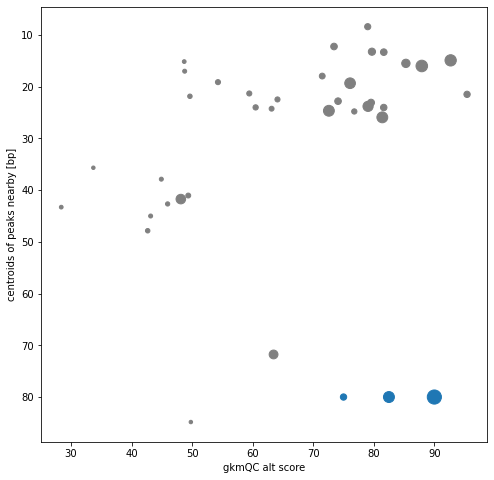

In [17]:
from scipy.stats import pearsonr, spearmanr

plt.figure(figsize=(8, 8))
scatter(x, y, s=y2, c="grey")
xlabel("gkmQC alt score")
ylabel("centroids of peaks nearby [bp]")
scatter([75, 82.5, 90], [80, 80, 80], s=[10 * sfactor, 30 * sfactor, 50 * sfactor])
# Backup codes for annotating dots
#for i, txt in enumerate(p):
#    plt.annotate(txt, (x[i], y[i]))
plt.gca().invert_yaxis()
plt.savefig("../output/Figure_3D.pdf")
spearmanr(x, y)

SpearmanrResult(correlation=-0.4033895940979953, pvalue=0.016264857133648607)

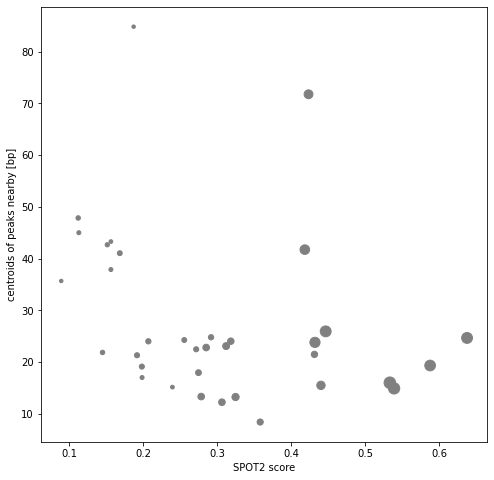

In [18]:
plt.figure(figsize=(8, 8))
scatter(w, y, s=y2, c="grey")
xlabel("SPOT2 score")
ylabel("centroids of peaks nearby [bp]")
plt.savefig("../output/Figure_3E.pdf")
spearmanr(w, y)